In [1]:
# Libary Imports
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.stats import norm,t

# Local Import
sys.path.insert(0, '../')
from utility import histnorm,load_currency
from tail_mle import power_law_fit, bootstrap_tail

In [2]:
# Load Data
df = load_currency('DASH',columns=['logclose'])
df.head()

,logclose
time,
2018-01-02 11:00:00,6.996672
2018-01-02 12:00:00,6.993116
2018-01-02 13:00:00,7.015380
2018-01-02 14:00:00,7.007057
2018-01-02 15:00:00,7.003320


In [3]:
# Log Returns
r = df['logclose'].diff().dropna()

# Aggregate log returns
# r = r.resample('D').sum()

# QQ-Plot

Text(0.5, 1.0, 'QQ Plot Students t-Distribution')

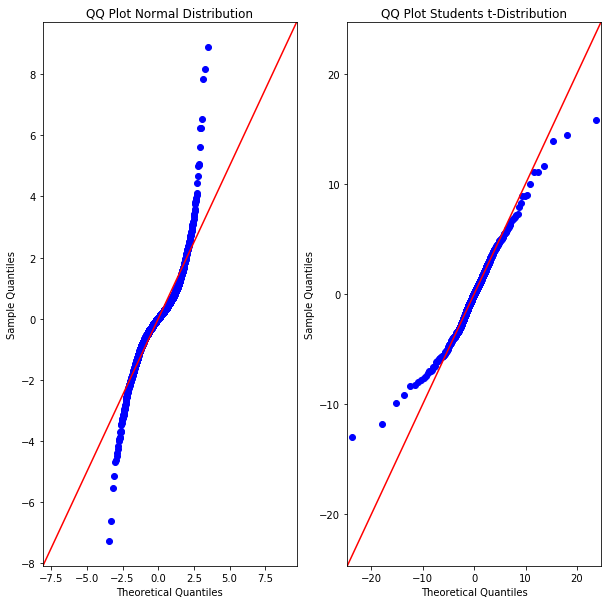

In [4]:
# Plot of empirical CCDF vs Gaussian
from statsmodels.graphics.gofplots import qqplot
fig,ax = plt.subplots(1,2,figsize=(10,10))
qqplot(r, dist='norm',fit=True, line ='45',ax=ax[0]) 
qqplot(r, dist='t',fit=True, line ='45',ax=ax[1])
ax[0].set_title('QQ Plot Normal Distribution')
ax[1].set_title('QQ Plot Students t-Distribution')


# Rank-frequency Plot

In [5]:
## Estimate emprical CCDF for log returns
# Compute Ranks
r_sorted = r.sort_values(ascending=True)
r_ranks = np.array(range(len(r_sorted)))

# Compute CCDF
N = len(r_sorted)
y1 = 1 - r_ranks/(N+1) 

## Estimate emprical CCDF for log loss
# Compute Ranks
l = -r
l_sorted = l.sort_values(ascending=True)
l_ranks = np.array(range(len(l_sorted)))

# Compute CCDF
N = len(l_sorted)
y2 = 1 - l_ranks/(N+1) 


##  Estimate Gaussian CCDF
# Define point grid between min and max log return
nbins = 100
x = np.linspace(np.min(r),np.max(r),nbins)  

# Compute Gaussian CCDF
mean, std = norm.fit(r)
c = 0.5*(1 - erf((r_sorted-mean)/(std*np.sqrt(2))))

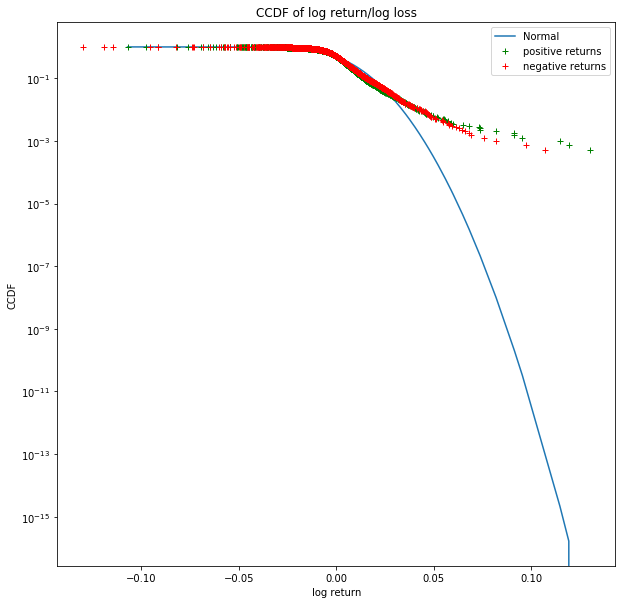

In [6]:
# Plot results
fig,ax = plt.subplots(figsize=(10,10))

ax.semilogy(r_sorted,c,label='Normal')
ax.semilogy(r_sorted,y1,'g+', label='positive returns')
ax.semilogy(l_sorted,y2,'r+', label='negative returns')
ax.set_title('CCDF of log return/log loss')
ax.set_xlabel('log return')
ax.set_ylabel('CCDF')
ax.legend()

# Power Law Tail Fit

Right tail exponent: 1.9326346762861182


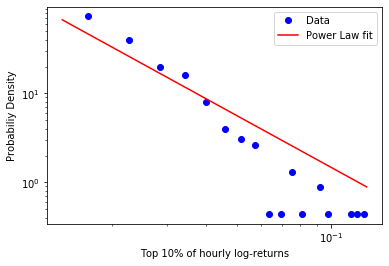

In [7]:
# Fitting the Right Tail of the sample data
alpha_right,right_tail = power_law_fit(r,'right')
print(f'Right tail exponent: {alpha_right}')

# Define Grid
x = np.linspace(min(right_tail),max(right_tail),100)

# Power law Distribution
power_law = ((alpha_right-1)/min(right_tail))*(x/min(right_tail))**(-alpha_right)

# Empirical Distribution
f,bin_centers = histnorm(right_tail,n_bins= 20)

# Plot the Right Tail Fit
fig,ax = plt.subplots()
ax.loglog(bin_centers,f,'bo',label="Data")
ax.loglog(x,power_law,'r',label='Power Law fit')
ax.set_xlabel('Top 10% of hourly log-returns')
ax.set_ylabel('Probabiliy Density')
ax.legend()

Left tail exponent: 2.079980716931803


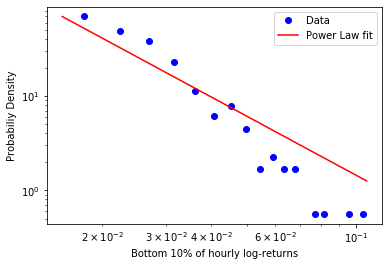

In [8]:
# Fitting the Left Tail of the sample data
alpha_left,left_tail = power_law_fit(r,'left')
print(f'Left tail exponent: {alpha_left}')

# Define Grid
x = np.linspace(min(left_tail),max(left_tail),100)

# Power law Distribution
power_law = ((alpha_left-1)/min(left_tail))*(x/min(left_tail))**(-alpha_left)

# Empirical Distribution
f,bin_centers = histnorm(left_tail,n_bins= 20)

# Plot the Right Tail Fit
fig,ax = plt.subplots()
ax.loglog(bin_centers,f,'bo',label="Data")
ax.loglog(x,power_law,'r',label='Power Law fit')
ax.set_xlabel('Bottom 10% of hourly log-returns')
ax.set_ylabel('Probabiliy Density')
ax.legend()

# Bootstrapping Confidence Interval of Tail Exponent

In [9]:
CI_left, CI_right, alpha_bts = bootstrap_tail(r, Nbts=10000, bts=0.8, p=0.9,tail='right')

print(f'Right tail interval at CL: [{CI_left:.2f} ; {CI_right:.2f}]')

CI_left, CI_right, alpha_bts = bootstrap_tail(r, Nbts=10000, bts=0.8, p=0.9,tail='left')

print(f'Left tail interval at CL: [{CI_left:.2f} ; {CI_right:.2f}]')

Right tail interval at CL: [1.86 ; 2.00]
Left tail interval at CL: [1.99 ; 2.14]


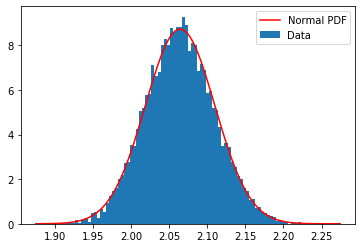

In [10]:
# Fit Normal Distribution for Alpha Values
x = np.linspace(min(alpha_bts),max(alpha_bts),200)
mu,sigma = norm.fit(alpha_bts)

fig,ax = plt.subplots()
ax.hist(alpha_bts,100,density=True,label='Data')
ax.plot(x,norm.pdf(x,loc = mu, scale = sigma),'r',label ='Normal PDF')
ax.legend()